# Objective

*Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.We strive to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, We make use of a variety of alternative data--including telco and transactional information--to* **predict their clients' repayment abilities.**

# Data Collection

Data is collected from kaggle competition HOME CREDIT RISK DEFAULT using Kaggle API

*https://www.kaggle.com/competitions/home-credit-default-risk/data*

* Install the required packages

In [0]:
%sh 
pip install kaggle
pip install mlflow

  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=74ee1bcd61ebe83128f9b49a17966f2811b3fc0970bfad56523aeef097107207
  Stored in directory: /root/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
Successfully built kaggle
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.
  Created wheel for databricks-cli: filename=databricks_cli-0.16.6-py3-none-any.whl size=112628 sha256=0e53ac8afe13d7a99f368966fd6382614bdf2c102d8ba6ab2ad4aedc2866ae97
  Stored in directory: /root/.cache/pip/wheels/76/3a/2f/8a3d92bc72a413217b5c8649e2044d7161cacbe06e014361a3
Successfully built databricks-cli
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.


* Delete any existisng .csv files in /databricks/driver directory

In [0]:
%sh
rm  /databricks/driver/*.csv

rm: cannot remove '/databricks/driver/*.csv': No such file or directory


* Download dataset from Kaggel

In [0]:
%sh
export KAGGLE_USERNAME=testkvr
export KAGGLE_KEY=306353bbdee2b3dca64e182b05908918
kaggle competitions download -c home-credit-default-risk
unzip home-credit-default-risk.zip


  0%|          | 0.00/688M [00:00<?, ?B/s]
  1%|          | 5.00M/688M [00:00<00:17, 39.9MB/s]
  1%|▏         | 9.00M/688M [00:00<00:19, 37.3MB/s]
  2%|▏         | 17.0M/688M [00:00<00:14, 48.0MB/s]
  4%|▎         | 25.0M/688M [00:00<00:12, 55.1MB/s]
  5%|▍         | 33.0M/688M [00:00<00:12, 54.6MB/s]
  6%|▌         | 41.0M/688M [00:00<00:11, 57.1MB/s]
  7%|▋         | 49.0M/688M [00:00<00:11, 59.6MB/s]
  8%|▊         | 57.0M/688M [00:01<00:10, 61.4MB/s]
  9%|▉         | 65.0M/688M [00:01<00:09, 66.3MB/s]
 11%|█         | 74.0M/688M [00:01<00:08, 72.8MB/s]
 12%|█▏        | 82.0M/688M [00:01<00:08, 71.2MB/s]
 13%|█▎        | 89.0M/688M [00:01<00:08, 71.3MB/s]
 14%|█▍        | 97.0M/688M [00:01<00:08, 70.9MB/s]
 15%|█▌        | 105M/688M [00:01<00:08, 74.0MB/s] 
 17%|█▋        | 116M/688M [00:01<00:07, 84.7MB/s]
 18%|█▊        | 125M/688M [00:01<00:06, 85.6MB/s]
 19%|█▉        | 134M/688M [00:02<00:06, 87.4MB/s]
 21%|██        | 144M/688M [00:02<00:06, 92.0MB/s]
 22%|██▏       | 153M/68

In [0]:
%sh
ls  "/databricks/driver/"

HomeCredit_columns_description.csv
POS_CASH_balance.csv
application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
conf
credit_card_balance.csv
eventlogs
ganglia
home-credit-default-risk.zip
installments_payments.csv
logs
metastore_db
preload_class.lst
previous_application.csv
sample_submission.csv


* Importing required packages

In [0]:
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import seaborn as sns
import pyspark.sql.functions as F

* Read the Data

In [0]:
home_credit_df = spark.read.csv('file:///databricks/driver/application_train.csv', inferSchema=True, header=True, mode='DROPMALFORMED')


In [0]:
display(home_credit_df.limit(5))

SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,null,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.08303696739132256,0.2629485927471776,0.13937578009978951,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003540999999999999,-16765,-1188,-1186.0,-291,null,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.3112673113812225,0.6222457752555098,null,0.0959,0.0529,0.9851,0.7959999999999999,0.0605,0.08,0.0345,0.2917,0.3333,0.013,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.804,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,null,0.5559120833904428,0.7295666907060153,null,null,null,null,null,null,null,null,null,null,null,n

# Exploratory Data Analysis

In [0]:
home_credit_df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

In [0]:
display(home_credit_df.summary())

summary,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511,307511,307511,307511,307511,307511,307511,307511,307511,307499,307233,306219,307511,307511,307511,307511,307511,307511,307511,307511,307511,104582,307511,307511,307511,307511,307511,307511,211120,307509,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,134133,306851,246546,151450,127568,157504,103023,92646,143620,152683,154491,98869,124921,97312,153161,93997,137829,151450,127568,157504,103023,92646,143620,152683,154491,98869,124921,97312,153161,93997,137829,151450,127568,157504,103023,92646,143620,152683,154491,98869,124921,97312,153161,93997,137829,97216,153214,159080,151170,161756,306490,306490,306490,306490,307510,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,307511,265992,265992,265992,265992,265992,265992
mean,278180.51857657125,0.08072881945686496,null,null,null,null,0.4170517477423572,168797.9192969845,599025.9997057016,27108.573909183444,538396.2074288895,null,null,null,null,null,0.020868112057779956,-16036.995066843137,63815.04590404896,-4986.120327538419,-2994.2023732484367,12.061090818687727,0.9999967480838083,0.8198893698111612,0.1993684778755882,0.9981334001060125,0.28106636835755466,0.0567199222141647,null,2.152665450442101,2.0524631639193394,2.031520823645333,null,12.063418869568894,0.015144173704355291,0.05076891558350758,0.04065870814377372,0.07817281333025486,0.23045354475124466,0.17955455252007246,null,0.5021298056566629,0.5143926741308493,0.5108529061799763,0.11744049917464455,0.08844221905179937,0.977734858162356,0.7524714325927213,0.044620715411350646,0.07894151232418825,0.1497246700680518,0.22628190703667433,0.23189350049054103,0.06633318417239686,0.10077477495067379,0.1073990193325975,0.008808672617211482,0.02835

**Data Explaination** <br>
*From the Above it is observed that the data set consis of *307511* records with *122* features.<br>
Target Column is *TARGET* with Values 1 and 0.   
Value 1 indicates client with payment difficulties, 0 Payment on time.
Features columns  are the Static data for all applications which explainns the varius status of the applicant. One row represents one loan in our data sample.*

**Data Visualization**

* Plotting Gender vs Loan Repayment count show that Male are more likey to Repay the loan compared to Female

In [0]:
display(home_credit_df.groupby("CODE_GENDER").agg({"TARGET":"sum"}).withColumnRenamed("sum(TARGET)","LoanRepaymentCount"))

CODE_GENDER,LoanRepaymentCount
F,14170
M,10655
XNA,0


* Plotting the Graph to analyze which class of people are more unlikely to pay back the loan.

In [0]:

display(home_credit_df
                      .select("NAME_INCOME_TYPE","TARGET")
                       .groupby("NAME_INCOME_TYPE")
                      .agg({"TARGET":"sum"})
                      .withColumnRenamed("sum(TARGET)","LoanRepaymentCount")
                      
       )

NAME_INCOME_TYPE,LoanRepaymentCount
Student,0
Commercial associate,5360
Businessman,0
State servant,1249
Working,15224
Pensioner,2982
Unemployed,8
Maternity leave,2


* Plotting the Graph to analyze people of which Occupation are more unlikely to pay back the loan.

In [0]:

display(home_credit_df
                      .select("OCCUPATION_TYPE","TARGET")
                       .filter(~(F.col("OCCUPATION_TYPE")==""))
                       .groupby("OCCUPATION_TYPE")
                      .agg({"TARGET":"sum"})
                      .withColumnRenamed("sum(TARGET)","LoanRepaymentCount")
                       
                      
       )


OCCUPATION_TYPE,LoanRepaymentCount
Managers,1328
HR staff,36
Medicine staff,572
Accountants,474
Laborers,5838
Cleaning staff,447
Private service staff,175
Drivers,2107
Sales staff,3092
Realty agents,59


**Feature Selection**

* Check for correlation and Remove the Highly correlated features

Out[13]: <AxesSubplot:>

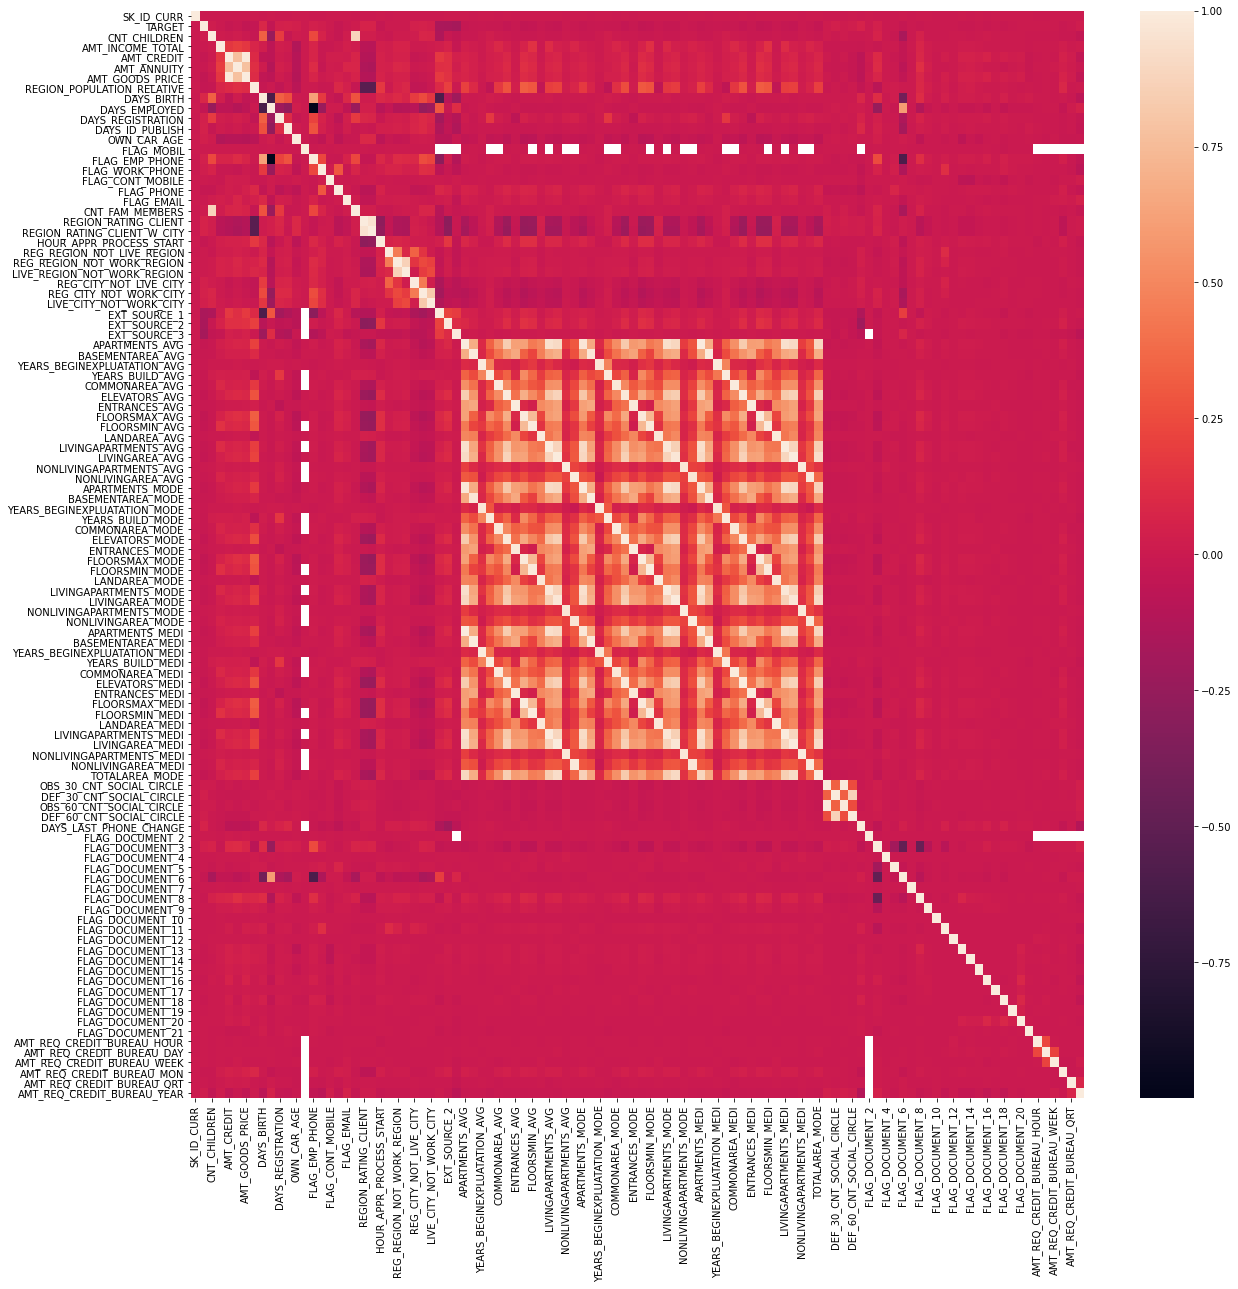

In [0]:
pdata = home_credit_df.toPandas()
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
corr = pdata.corr()
sns.heatmap(corr)

*From the above  Heat map we observe that the there are many features which are higly correlated .Hence removed these highly correlated fields from Prediction*

In [0]:
corr_remove_list =['LIVE_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT_W_CITY','AMT_ANNUITY','AMT_GOODS_PRICE','APARTMENTS_AVG',
 'BASEMENTAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','YEARS_BUILD_AVG','COMMONAREA_AVG','ELEVATORS_AVG','ENTRANCES_AVG',
 'FLOORSMAX_AVG','FLOORSMIN_AVG','LANDAREA_AVG','LIVINGAPARTMENTS_AVG','LIVINGAREA_AVG','NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG','APARTMENTS_MODE','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE',
 'ELEVATORS_MODE','ENTRANCES_MODE','FLOORSMAX_MODE','FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE','LIVINGAREA_MODE',
  'NONLIVINGAPARTMENTS_MODE','NONLIVINGAREA_MODE','APARTMENTS_MEDI','BASEMENTAREA_MEDI','YEARS_BEGINEXPLUATATION_MEDI',
'YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','ENTRANCES_MEDI','FLOORSMAX_MEDI','FLOORSMIN_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI','LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','FONDKAPREMONT_MODE','HOUSETYPE_MODE',
'TOTALAREA_MODE','WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE','NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG','APARTMENTS_MODE','LIVINGAPARTMENTS_MODE','YEARS_BUILD_MEDI','COMMONAREA_MEDI','ELEVATORS_MEDI','FLOORSMIN_MEDI','LIVINGAPARTMENTS_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI','AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR','DAYS_LAST_PHONE_CHANGE','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','YEARS_BUILD_AVG','COMMONAREA_AVG','FLOORSMIN_AVG','LIVINGAPARTMENTS_AVG','LANDAREA_AVG','NONLIVINGAPARTMENTS_MODE',
'NONLIVINGAREA_MODE','YEARS_BUILD_MODE','COMMONAREA_MODE','FLOORSMIN_MODE']

In [0]:
feature_cols = [col for col in home_credit_df.columns  if col not in corr_remove_list ]
len(feature_cols)

Out[15]: 61

Out[16]: <AxesSubplot:>

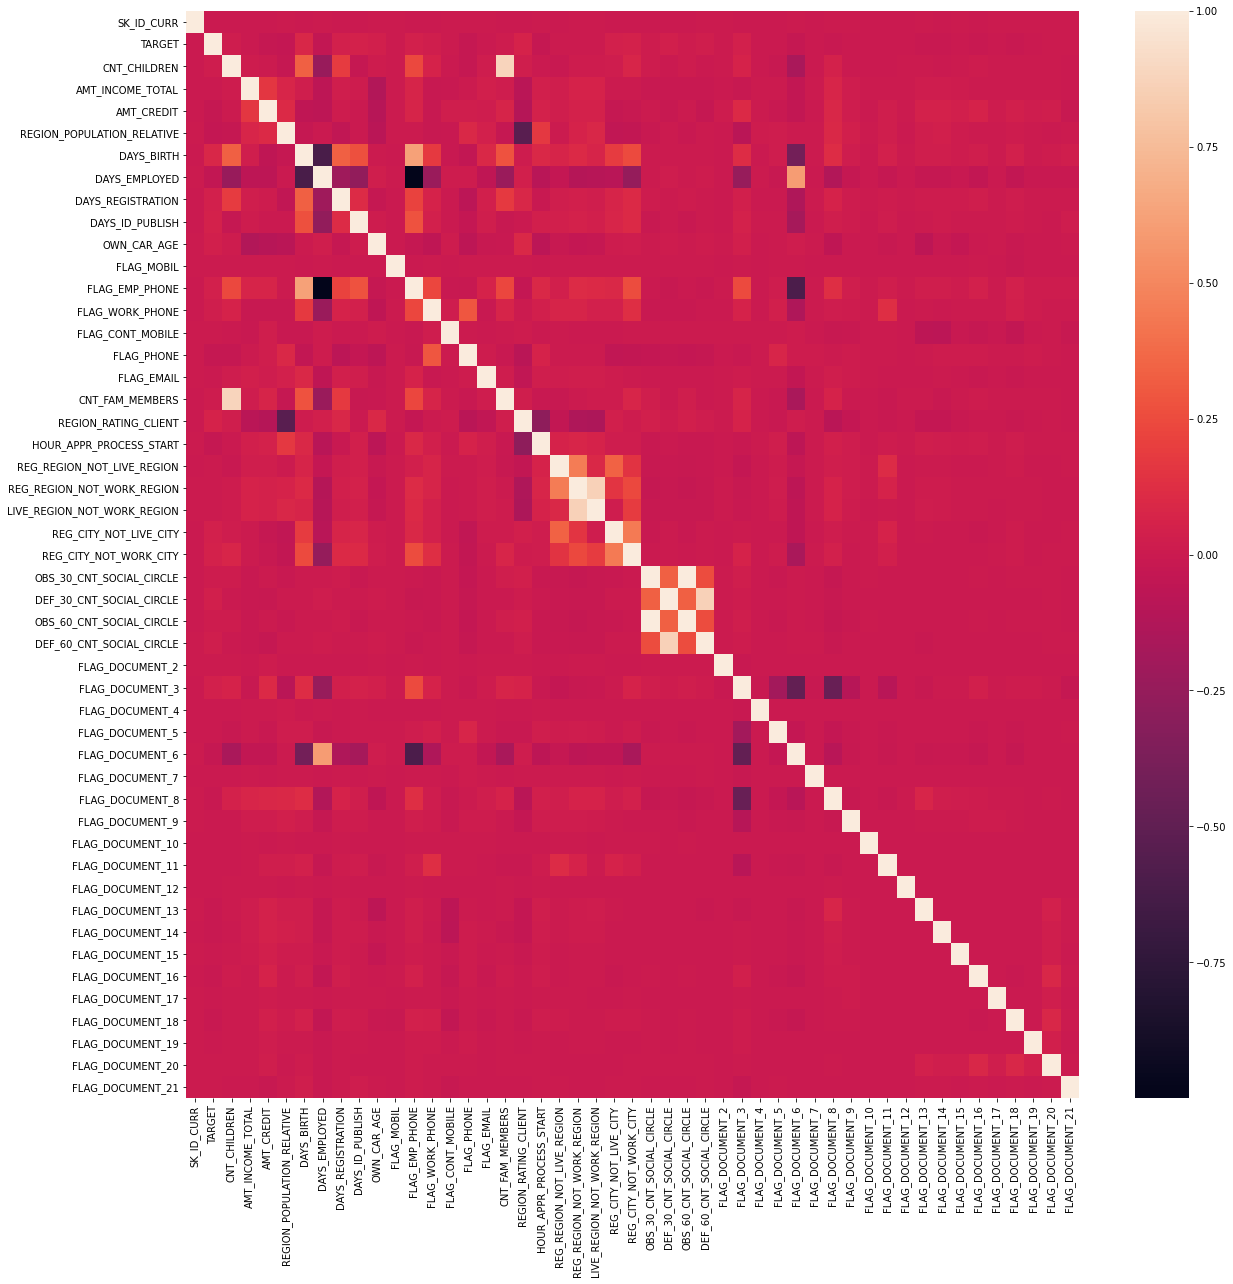

In [0]:
pdata = home_credit_df.select(feature_cols).toPandas()
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
corr = pdata.corr()
sns.heatmap(corr)

*After Removing the CORRERALETD columns , we see that now the Heat map shows that correlation is reduced*

In [0]:
# Selecting the required features for Modeling
home_credit_df = home_credit_df.select(feature_cols)
print("Total Features  selected are {}".format(home_credit_df.columns))

Total Features  selected are ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT

*Data Cleaning -Dropping Nulls*

In [0]:
#Remove the Null/NA values
print("Rows Befor Dropping Nulls: {}".format(home_credit_df.count()))
df = home_credit_df.dropna()
print("Rows After dropna",format(df.count()))

Rows Befor Dropping Nulls: 307511
Rows After dropna 79607


# Data Transformation

In [0]:
splitted_data = df.randomSplit([0.7, 0.3], 24)   # proportions [], seed for random
train_data = splitted_data[0]
test_data = splitted_data[1]

print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))

Number of training records: 55580
Number of testing records : 24027


*Created a pipeline to converts all the string columns to numeric*

In [0]:
stringIndexer_contract = StringIndexer(inputCol="NAME_CONTRACT_TYPE", outputCol="NAME_CONTRACT_TYPE_IX")
stringIndexer_gender = StringIndexer(inputCol="CODE_GENDER", outputCol="CODE_GENDER_IX")
stringIndexer_car = StringIndexer(inputCol="FLAG_OWN_CAR", outputCol="FLAG_OWN_CAR_IX")
stringIndexer_realty = StringIndexer(inputCol="FLAG_OWN_REALTY", outputCol="FLAG_OWN_REALTY_IX")
stringIndexer_suite = StringIndexer(inputCol="NAME_TYPE_SUITE", outputCol="NAME_TYPE_SUITE_IX")
stringIndexer_income = StringIndexer(inputCol="NAME_INCOME_TYPE", outputCol="NAME_INCOME_TYPE_IX")
stringIndexer_education = StringIndexer(inputCol="NAME_EDUCATION_TYPE", outputCol="NAME_EDUCATION_TYPE_IX")
stringIndexer_family_status = StringIndexer(inputCol="NAME_FAMILY_STATUS", outputCol="NAME_FAMILY_STATUS_IX")
stringIndexer_housing_type = StringIndexer(inputCol="NAME_HOUSING_TYPE", outputCol="NAME_HOUSING_TYPE_IX")
stringIndexer_occupation = StringIndexer(inputCol="OCCUPATION_TYPE", outputCol="OCCUPATION_TYPE_IX")
stringIndexer_appr_process_start = StringIndexer(inputCol="WEEKDAY_APPR_PROCESS_START", outputCol="WEEKDAY_APPR_PROCESS_START_IX")


columns = train_data.columns
for i in train_data.dtypes:
    if(i[1]=='string'):
        columns.remove(i[0])

columns.remove('SK_ID_CURR')

columns = columns + ['NAME_CONTRACT_TYPE_IX',
                     'CODE_GENDER_IX',
                     'FLAG_OWN_CAR_IX',
                     'FLAG_OWN_REALTY_IX',
                     'NAME_TYPE_SUITE_IX',
                     'NAME_INCOME_TYPE_IX',
                     'NAME_EDUCATION_TYPE_IX',
                     'NAME_FAMILY_STATUS_IX',
                     'NAME_HOUSING_TYPE_IX',
                     'OCCUPATION_TYPE_IX',
                     'WEEKDAY_APPR_PROCESS_START_IX']

# CREATING THE DATA TRANFORMATION PIPELINE
pipeline = Pipeline(stages=[stringIndexer_contract, 
                            stringIndexer_gender, 
                            stringIndexer_car, 
                            stringIndexer_realty,
                            stringIndexer_suite,
                            stringIndexer_income,
                            stringIndexer_education,
                            stringIndexer_family_status,
                            stringIndexer_housing_type,
                            stringIndexer_occupation, 
                            stringIndexer_appr_process_start
                           ])
                            
train_data = pipeline.fit(train_data).transform(train_data)
test_data = pipeline.fit(test_data).transform(test_data)


# Modeling & Tuning

*Data Modeling and Tuning using Paramgrid and CrossValidation*

In [0]:
#Creating a feature columns
vectorAssembler_features = VectorAssembler(inputCols=columns, outputCol="features")

#Baseline Model(RandomForestClassifier) creation using TARGET as label column
rf = RandomForestClassifier(labelCol ="TARGET")

#Creating the Pipeline  for modeling
pipeline2=Pipeline(stages=[vectorAssembler_features,rf])
evaluator = MulticlassClassificationEvaluator(
    labelCol="TARGET", predictionCol="prediction", metricName="accuracy")

#Defining Param grid
params = ParamGridBuilder()\
  .addGrid(rf.numTrees, range(2,5))\
  .build()

#Defining a cross Validator
cv = CrossValidator()\
    .setEstimator(pipeline2)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(params)\
    .setNumFolds(2)

#Fitting the model with Training data
fittedGrid=cv.fit(train_data)


# Prediction and Evaluation

In [0]:
#Predictions using best model with test data
rfBest = fittedGrid.bestModel
predictions = rfBest.transform(test_data)
display(predictions.select("features","TARGET","PREDICTION").limit(30))

features,TARGET,PREDICTION
"Map(vectorType -> sparse, length -> 59, indices -> List(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 23, 24, 25, 26, 29, 51, 57, 58), values -> List(2.0, 135000.0, 247500.0, 0.026392000000000002, -11286.0, -746.0, -108.0, -3729.0, 7.0, 1.0, 1.0, 1.0, 4.0, 2.0, 14.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0))",0,0.0
"Map(vectorType -> sparse, length -> 59, indices -> List(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 24, 26, 48, 54, 57), values -> List(180000.0, 540000.0, 0.025164, -16126.0, -1761.0, -8236.0, -4292.0, 3.0, 1.0, 1.0, 1.0, 2.0, 2.0, 8.0, 1.0, 1.0, 1.0, 1.0, 2.0))",0,0.0
"Map(vectorType -> sparse, length -> 59, indices -> List(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 34, 54, 55, 57), values -> List(540000.0, 1227901.5, 0.032561, -20544.0, -2091.0, -6846.0, -566.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 14.0, 1.0, 1.0, 4.0, 2.0))",0,0.0
"Map(vectorType -> sparse, length -> 59, indices -> List(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 29, 49, 53, 54, 57), values -> List(180000.0, 1035000.0, 0.028663, -19550.0, -4856.0, -6836.0, -3084.0, 21.0, 1.0, 1.0, 1.0, 2.0, 2.0, 9.0, 1.0, 1.0, 2.0, 1.0, 3.0))",0,0.0
"Map(vectorType -> sparse, length -> 59, indices -> List(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 23, 29, 54, 57, 58), values -> List(2.0, 202500.0, 796396.5, 0.008019, -15909.0, -1094.0, -3134.0, -4180.0, 65.0, 1.0, 1.0, 1.0, 1.0, 4.0, 2.0, 17.0, 1.0, 1.0, 1.0, 2.0, 4.0))",0,0.0
"Map(vectorType -> sparse, length -> 59, indices -> List(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 34, 49, 53, 54, 55, 57, 58), values -> List(202500.0, 343377.0, 0.072508, -18138.0, -969.0, -7421.0, -1681.0, 5.0, 1.0, 1.0, 1.0, 1.0, 1.0, 13.0, 1.0, 1.0, 2.0, 1.0, 1.0, 5.0, 1.0))",0,0.0
"Map(vectorType -> sparse, length -> 59, indices -> List(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 23, 29, 53, 58), values -> List(3.0, 135000.0, 373140.0, 0.035792000000000004, -10744.0, -741.0, -442.0, -2381.0, 21.0, 1.0, 1.0, 1.0, 5.0, 2.0, 9.0, 1.0, 1.0, 1.0, 1.0))",0,0.0
"Map(vectorType -> sparse, length -> 59, indices -> List(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 24, 26, 29, 49, 51, 53, 56, 57, 58), values -> List(1.0, 112500.0, 862560.0, 0.0228, -10485.0, -1249.0, -4628.0, -3110.0, 17.0, 1.0, 1.0, 1.0, 3.0, 2.0, 11.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 2.0))",0,0.0
"Map(vectorType -> sparse, length -> 59, indices -> List(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 24, 26, 29, 51, 53, 54, 58), values -> List(162000.0, 263686.5, 0.022625, -13972.0, -4472.0, -464.0, -4529.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 16.0, 5.0, 5.0, 1.0, 1.0, 1.0, 1.0, 3.0))",0,0.0
"Map(vectorType -> sparse, length -> 59, indices -> List(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 23, 24, 26, 34), values -> List(112500.0, 312768.0, 0.028663, -23187.0, -1896.0, -5213.0, -4265.0, 21.0, 1.0, 1.0, 1.0, 2.0, 2.0, 16.0, 1.0, 2.0, 2.0, 1.0))",0,0.0


In [0]:
#Model Evaluation
evaluatorRF = MulticlassClassificationEvaluator(labelCol="TARGET", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)
# accuracy=fittedGrid.bestModel.stages[1].summary.accuracy
print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.978316
Test Error = 0.0216839


*Confusion Matrix*

In [0]:
display(predictions.groupby("TARGET").pivot("prediction").count())

TARGET,0.0,1.0
1,521,1349
0,22157,null


*Plotting ROC curve*

/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


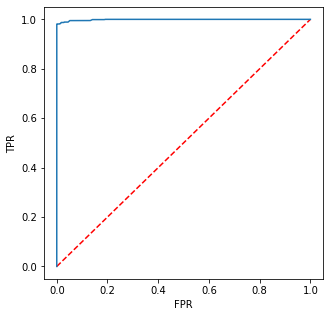

In [0]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(rfBest.stages[1].summary.roc.select('FPR').collect(),
         rfBest.stages[1].summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [0]:
print("Area Under Curve is {}".format(rfBest.stages[1].summary.areaUnderROC))

Area Under Curve is 0.9988458705582708
